# Predictive Maintenance for the Turbofan Engine Dataset

## 학습/누적학습 시키는 방법
#### 1. 트레인셋은 분할된 것, 테스트셋은 2p, 4p, 15p 처럼 완전한 데이터
#### 2. 제일 처음 학습을 시킬 때 [학습시킨 모델 저장/불러오기] 단계까지 쭉 진행
#### 3. 누적학습이 필요하면 [Train, Test Set 넣어주기] 에서 분할된 다음 트레인셋 넣고 [학습시킨 모델 저장/불러오기] 단계까지 진행하고를 반복
#### 4. 누적학습까지 다 완료 되면 플롯 그래프 그리는 곳까지 쭉 실행하면 됨
#### 👏 만약 아예 새로 돌리고 싶다면 wtte_reuse_model.h5를 지우기
#### ===================================================================
#### 👏 !! 한 번 학습이 끝나면 반드시 model.save, 학습을 이어서 하기 전에는 model_load로 저장된 모델을 불러와야 하니 안까먹고 꼭 저장하고 불러오기 하기 !! 안그러면 모델 초기화돼서 다시 돌려야함 !! 👏

##Data Preparation

In [ ]:
import keras
import keras.backend as K

print ("Keras version", keras.__version__)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Nadam

# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)  

Keras version 2.4.3


In [ ]:
!mkdir Dataset
!mkdir Models

!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_test.txt -O Dataset/PM_test.txt 
!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_train.txt -O Dataset/PM_train.txt  
!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_truth.txt -O Dataset/PM_truth.txt
  
!ls Dataset

PM_test.txt  PM_train.txt  PM_truth.txt


### Train, Test Set 넣어주기


In [ ]:
from sklearn import preprocessing

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('Dataset/5_1_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[5, 6]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 's1', 's2', 's3']

train_df = train_df.sort_values(['id','cycle'])

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2', 'label3'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df[train_df["id"] == 1].tail()

,id,cycle,s1,s2,s3,RUL,cycle_norm
164,1,165,0.225564,0.0,0.206360,4,0.438503
165,1,166,0.180451,0.0,0.206360,3,0.441176
166,1,167,0.135338,0.0,0.206360,2,0.443850
167,1,168,0.097744,0.0,0.178359,1,0.446524
168,1,169,0.067669,0.0,0.178359,0,0.449198


In [ ]:
from sklearn import preprocessing

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('Dataset/5_1_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[5, 6]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 's1', 's2', 's3']

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('Dataset/my_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[test_df["id"] == 1].tail()

,id,cycle,s1,s2,s3,cycle_norm,RUL
6,1,7,0.124060,0.0,0.053547,0.016043,4.0
7,1,8,0.112782,0.0,0.046251,0.018717,3.0
8,1,9,0.097744,0.0,0.046251,0.021390,2.0
9,1,10,0.082707,0.0,0.046251,0.024064,1.0
10,1,11,0.067669,0.0,0.039983,0.026738,0.0


### Apply right padding to all the sequences

In [ ]:
def pad_sequence(df, max_seq_length, mask=0):
    """
    Applies right padding to a sequences until max_seq_length with mask 
    """
    return np.pad(df.values, ((0, max_seq_length - df.values.shape[0]), (0,0)), 
                  "constant", constant_values=mask)
  
def pad_engines(df, cols, max_batch_len, mask=0):
    """
    Applies right padding to the columns "cols" of all the engines 
    """
    return np.array([pad_sequence(df[df['id'] == batch_id][cols], max_batch_len, mask=mask) 
                     for batch_id in df['id'].unique()])
  
#max_batch_len = test_df['id'].value_counts().max()
max_batch_len = train_df['id'].value_counts().max()
train_cols = ['s' + str(i) for i in range(1,4)] + ['cycle_norm']
test_cols = ["RUL"]

X = pad_engines(train_df, train_cols, max_batch_len)
Y = pad_engines(train_df, test_cols, max_batch_len)

### train, validation, test로 쪼개기

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.20, random_state=SEED)

# Test set from CMAPSS
test_X = pad_engines(test_df, train_cols, max_batch_len)
test_Y = pad_engines(test_df, test_cols, max_batch_len)

# In the WTTE-RNN architecture we will predict 2 parameters (alpha and beta)
# alpha is initialised to 1
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=2)
val_Y_wtte = np.concatenate((val_Y, np.ones(val_Y.shape)), axis=2)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=2)

print ("Train:\n", "  X:", train_X.shape, "\n  Y:", train_Y.shape, "\n  Y_wtte:", train_Y_wtte.shape)
print ("\nValidation:\n", "  X:", val_X.shape, "\n  Y:", val_Y.shape, "\n  Y_wtte:", val_Y_wtte.shape)
print ("\nTest:\n", "  X:", test_X.shape, "\n  Y:", test_Y.shape, "\n  Y_wtte:", test_Y_wtte.shape)

Train:
   X: (6, 375, 4) 
  Y: (6, 375, 1) 
  Y_wtte: (6, 375, 2)

Validation:
   X: (2, 375, 4) 
  Y: (2, 375, 1) 
  Y_wtte: (2, 375, 2)

Test:
   X: (4, 375, 4) 
  Y: (4, 375, 1) 
  Y_wtte: (4, 375, 2)


### Plot 그리기 위한 함수

In [ ]:
%matplotlib inline
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_and_plot(model, evaluation_data, weibull_function=None):
    """
    Generate scores dataframe and plot the RUL
    """
    fig = plt.figure()
    i = 1
    score_df = pd.DataFrame({"Method": ["MAE", "RMSE", "R2"]})
    for name_set, train_set, test_set in evaluation_data:
        if weibull_function is None:
            y_pred = model.predict(train_set).flatten()
        else:
            y_pred = [weibull_function(alpha, beta) 
                      for batch in model.predict(train_set) 
                      for beta, alpha in batch]
        l = test_set[:,:,0].flatten()
        # To validate we remove the right padding
        y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
        y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
        score_mae = "{0:.2f}".format(mean_absolute_error(y_true, y_pred))
        score_rmse = "{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred)))
        score_r2 = "{0:.3f}".format(r2_score(y_true, y_pred))
        score_df[name_set] = [score_mae, score_rmse, score_r2]
        ax = fig.add_subplot(6, 1, i)
        ax.title.set_text(name_set)
        ax.title.set_fontsize(20)
        i += 1
        plt.plot(y_pred[0:2500])
        plt.plot(y_true[0:2500])
        plt.axis([0,2500,0,500])
        ax = fig.add_subplot(6, 1, i)
        i += 1
        plt.plot(y_pred[2500:5000])
        plt.plot(y_true[2500:5000])
        plt.axis([0,2500,0,500])
    plt.subplots_adjust(hspace=0.45)
    plt.axis([0,2500,0,500])
    fig.set_size_inches(15, i*2.2)
    return score_df.T


SyntaxError: ignored

## WTTE-RNN

In [ ]:
# Install wtte package from Martinsson

!pip install wtte

In [ ]:
# Loss and activation functions from Martinsson
# These are not used in the final version because 
# the wtte package has useful regularization tools

def weibull_loglik_discrete(y_true, y_pred, epsilon=K.epsilon()):
    y = y_true[..., 0]
    u = y_true[..., 1]
    a = y_pred[..., 0]
    b = y_pred[..., 1]
    
    hazard0 = K.pow((y + epsilon) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)

    loss = u * K.log(K.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return -loss

def activation_weibull(y_true):
    a = y_true[..., 0]
    b = y_true[..., 1]
    
    a = K.exp(a)
    b = K.sigmoid(b)
    return K.stack([a, b], axis=-1)

### WTTE-RNN 학습 초기화

In [ ]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Lambda ,SimpleRNN
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
import wtte.weibull as weibull
import wtte.wtte as wtte

# Since we use a lambda in the last layer the model 
# is not saved well in keras, instead we save the weights.
# This requires compiling the model to load the weights
baseline_wtte_path = "baseline_wtte_model_weights"
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_wtte_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=0)

nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

model.add(Masking(mask_value=0.,
                  input_shape=(max_batch_len, nb_features)))
model.add(SimpleRNN(
         input_shape=(None, nb_features),
         units=42,
         recurrent_dropout=0.01,
         return_sequences=True))
model.add(SimpleRNN(
         input_shape=(None, nb_features),
         units=32,
         recurrent_dropout=0.01,
         return_sequences=True))
model.add(SimpleRNN(
         input_shape=(None, nb_features),
         units=22,
         recurrent_dropout=0.01,
         return_sequences=True))
#model.add(SimpleRNN(
#         input_shape=(None, nb_features),
#         units=28,
#         recurrent_dropout=0.01,
#         return_sequences=True))
#model.add(LSTM(
#         input_shape=(None, nb_features),
#         units=20,
#         recurrent_dropout=0.01,
#         return_sequences=True))

model.add(TimeDistributed(Dense(2)))
# uncomment this line and comment the next to use 
#activation_weibull function:
#model.add(Activation(activation_weibull))
model.add(Lambda(wtte.output_lambda, 
                 arguments={# Initialization value around it's scale
                            "init_alpha": np.nanmean(train_Y_wtte[:,0]), 
                            # Set a maximum
                            "max_beta_value": 10.0
                           },
                ))
# Same for the loss "weibull_loglik_discrete"
# model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop')
# We use clipping on the loss
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function




### WTTE-RNN epoch 돌려 학습시키기 (초기화, 재학습)

In [ ]:


# 옵타마이저 참고 : https://wikidocs.net/36033
# 현아 : RMS 쓸거면
#model.compile(loss=loss, optimizer=RMSprop(lr=0.05, rho=0.9, epsilon=1e-06))
#model.compile(loss=loss, optimizer='rmsprop')

# 현아 : Nadam 쓸거면
#model.compile(loss=loss,optimizer=Nadam(lr=0.05,beta_1=0.9,beta_2=0.999,epsilon=1e-08,schedule_decay=0.004))

# 현아 : Adam 쓸거면
model.compile(loss=loss, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False))

# 영석 : 로그라이크,,?
#model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=0.075, rho=0.9, epsilon=1e-06))






# 학습시키기

print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=40, batch_size=200, 
                    validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
                    callbacks = [early_stopping, checkpoint, TerminateOnNaN()])

# list all data in history
print(history.history.keys())






Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 375, 4)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 375, 42)           1974      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 375, 32)           2400      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 375, 22)           1210      
_________________________________________________________________
time_distributed (TimeDistri (None, 375, 2)            46        
_________________________________________________________________
lambda (Lambda)              (None, 375, 2)            0         
Total params: 5,630
Trainable params: 5,630
Non-trainable params: 0
______________________________________________________

### 학습 시킨 모델 저장/불러오기(재학습을 위해 불러오기)

In [ ]:
# 모델 저장하기
from keras.models import load_model
model.save('wtte_reuse_model.h5')

In [ ]:
# 재학습을 위해 모델 불러오기
from keras.models import load_model
model= load_model("wtte_reuse_model_6.h5",
                  custom_objects = {"weibull_loglik_discrete": weibull_loglik_discrete,"activate":activation_weibull, 
                                    "loss_function":wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function})

### PLOT 그리기

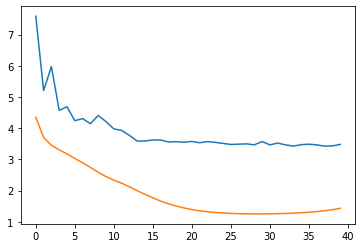

In [ ]:
%matplotlib inline


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

### Weibull Methods

$\mu = \beta\Gamma(1 + \alpha^{-1})$

$\sigma^2 = \beta^2[\Gamma(1 + 2\alpha^{-1}) - \Gamma^2(1 + \alpha^{-1})]$

$mode = \beta\frac{\alpha-1}{\alpha}^{1/\alpha}$

Inverse CDF $ = \beta (-\log(1 - x))^\frac{1}{\alpha} $ when $ 0<x<1 $

In [ ]:
from math import gamma, log, sqrt

def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha) if alpha > 1 else 0

def median_weibull(alpha, beta):
    return beta*(log(2)**(1./alpha))

def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)

def pdf_weibull(x, alpha, beta):
    return (alpha/beta)*(x/beta)**(alpha - 1)*np.exp(-(x/beta)**alpha)

def inverse_cdf_weibull(x, alpha, beta):
    return beta*np.power((-np.log(1.-x)), 1./alpha)

def survival_weibull(x, alpha, beta):
    return np.e**-((x/beta)**alpha)



### Mean, Mode and Median, 플롯 그래프 그리기



![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Visualisation_mode_median_mean.svg/150px-Visualisation_mode_median_mean.svg.png)

In [ ]:
# PLOT 그리기 전에 모델 불러오기
from keras.models import load_model
model= load_model("wtte_reuse_model_6.h5",
                  custom_objects = {"weibull_loglik_discrete": weibull_loglik_discrete,"activate":activation_weibull, 
                                    "loss_function":wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function})

Mode
                0       1         2
Method        MAE    RMSE        R2
Train       90.82  118.31    -0.431
Validation  87.52  126.67  -623.450
Test        53.13   70.25    -0.128

Median
                0       1         2
Method        MAE    RMSE        R2
Train       87.79  114.42    -0.339
Validation  92.35  132.90  -686.385
Test        57.73   74.68    -0.275

Mean
                 0       1         2
Method         MAE    RMSE        R2
Train        86.47  111.90    -0.280
Validation  117.91  141.27  -775.704
Test         60.12   77.30    -0.366


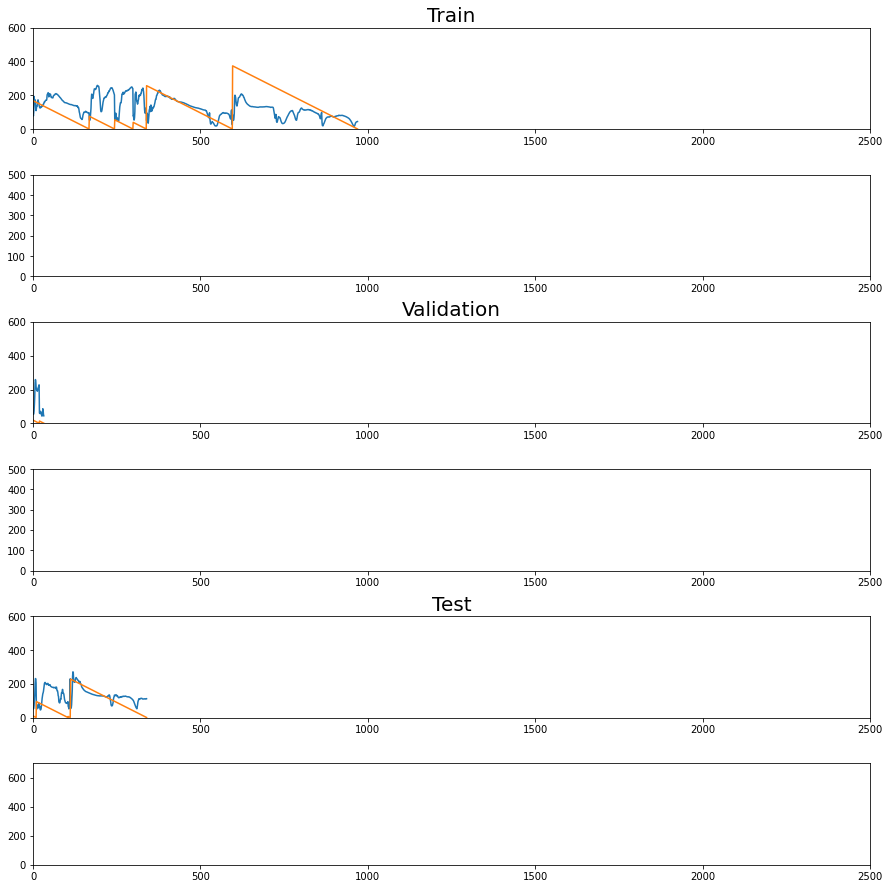

In [ ]:
%matplotlib inline

%matplotlib inline
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_and_plot(model, evaluation_data, weibull_function=None):
    """
    Generate scores dataframe and plot the RUL
    """
    fig = plt.figure()
    i = 1
    score_df = pd.DataFrame({"Method": ["MAE", "RMSE", "R2"]})
    for name_set, train_set, test_set in evaluation_data:
      #=========================================================================#
        if weibull_function is None:
            y_pred = model.predict(train_set).flatten()
        else:
            y_pred = [weibull_function(alpha, beta) 
                      for batch in model.predict(train_set) #------------train_set만큼 반복문 돌아감
                      for beta, alpha in batch] #----------------------------batch만큼 반복문 돌아감
     #=========================================================================#
        l = test_set[:,:,0].flatten()
        # To validate we remove the right padding
        y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
        y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
        #------------------------------------------------------------------------------------------------------MAE, RMSE, R2값
        score_mae = "{0:.2f}".format(mean_absolute_error(y_true, y_pred))
        score_rmse = "{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred)))
        score_r2 = "{0:.3f}".format(r2_score(y_true, y_pred))
        score_df[name_set] = [score_mae, score_rmse, score_r2]
        #-----------------------------------------------------------------------------------------------------------------------------
        ax = fig.add_subplot(6, 1, i) #----------------------------------그래프에 대한 위치 조정인 것 같음 (세로형태로 달라짐, 가로 형태로 달라짐, 건들이지 않는 게 좋을 것 같은 변수...)
        ax.title.set_text(name_set) #-----------------------------------그래프의 각각 이름
        ax.title.set_fontsize(20) #---------------------------------------그래프 이름의 크기
        i += 1  #-------------------------------------------------------------그래프의 위치 조정을 위해 사용되는 변수
        plt.plot(y_pred[0:2500])  #--------------------------------------예측한 데이터 모양: 그래프의 파란색 선
        #print("\ny_pred")
        #print(y_pred)
        plt.plot(y_true[0:2500])  #---------------------------------------실제 데이터 모양: 그래프의 주황색 선
        plt.axis([0,2500,0,600])  #---------------------------------------train, validation 그래프의 모두 첫번째
        ax = fig.add_subplot(6, 1, i)
        i += 1
        plt.plot(y_pred[2500:5000])
        plt.plot(y_true[2500:5000])
        plt.axis([0,2500,0,500])  #---------------------------------------train, validation, test 그래프의 모두 두번째
    plt.subplots_adjust(hspace=0.45)
    plt.axis([0,2500,0,700]) #-------------------------------------------test 두번째 그래프
    fig.set_size_inches(15, i*2.2)  #----------------------------------그래프 가로 길이 조절
    return score_df.T #--------------------------------------------------MAE, RMSE, R2값 리턴

print("Mode")
print (evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mode_weibull))
#print("train_1")
#print(train_Y_wtte)
#print("\nval_1")
#print(val_Y_wtte)
#print("\ntest_1")
#print(test_Y_wtte)

# comment the next line to visualise the plot for the mode
plt.close()

print("\nMedian")
print (evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = median_weibull))

#print("train_2")
#print(train_Y_wtte)
#print("\nval_2")
#print(val_Y_wtte)
#print("\ntest_2")
#print(test_Y_wtte)

# comment the next line to visualise the plot for the median
plt.close()

# We save the validation errors to later compare the models
validation_wtte = [mean_weibull(alpha, beta) 
                   for batch in model.predict(val_X) 
                   for beta, alpha in batch]

#print("\ntest")
#print(validation_wtte)

print("\nMean")
print(evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mean_weibull))

# 아래부터는 우리가 잘 안쓰는 코드 ...

### Evolution of the pdf through the cycles of an engine (PLOT)

In [ ]:
import random

import seaborn as sns


random.seed(SEED)
lot = random.sample(train_X, 3) 
random.seed(SEED)
lot += random.sample(val_X, 3)
random.seed(SEED)
lot += random.sample(test_X, 3)

palette = list(reversed(sns.color_palette("RdBu_r", 250)))

fig = plt.figure()
j = 1
for batch in lot:
    size = batch[~np.all(batch == 0, axis=1)].shape[0]
    y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
    y_pred_wtte = y_pred_wtte[:size]
    x = np.arange(1, 400.)
    
    freq = 5
    ax = fig.add_subplot(3, 3, j)
    
    i=0
    for beta, alpha in y_pred_wtte[0::freq][2:]:
        mean = mode_weibull(alpha, beta)
        color=palette[int(mean)] if i < len(palette) else palette[-1]
        plt.plot(x, pdf_weibull(x, alpha, beta), color=color)
        i += 1
    ax.set_ylim([0, 0.07])
    ax.set_xlim([0, 300])
    ax.set_yticklabels([])
    if j == 2:
        ax.title.set_text("Train")
    elif j == 5:
        ax.title.set_text("Validation")
    elif j == 8:
        ax.title.set_text("Test")
    j += 1

plt.subplots_adjust(wspace=0.15, hspace=0.25)
fig.set_size_inches(10,10)

### Confidence Interval of the Weibull Distribution

In [ ]:
%matplotlib inline

from scipy.stats import dweibull

batch = lot[0]
size = batch[~np.all(batch == 0, axis=1)].shape[0]
y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
y_pred_wtte = y_pred_wtte[:size]

fig = plt.figure()
fig.add_subplot(1,1,1)
for beta, alpha in y_pred_wtte[0::20]:
    x = np.arange(1, 300.)
    mean = mean_weibull(alpha, beta)
    sigma = np.sqrt(var_weibull(alpha, beta))
    plt.plot(x, pdf_weibull(x, alpha, beta), color=palette[int(mean)])
    # alpha is the shape parameter
    conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
    plt.fill([conf[0]] + list(np.arange(conf[0], conf[1])) + [conf[1]], 
             [0] + list(pdf_weibull(np.arange(conf[0], conf[1]), alpha, beta)) + [0], 
             color=palette[int(mean)], alpha=0.5)

axes = plt.gca()
axes.set_ylim([0., 0.06])
axes.set_xlim([0., 300.])
fig.set_size_inches(10,5)

### Evolution of the pdf through the cycles of an engine (GIFs)

In [ ]:
import sys
import random
from math import gamma

from matplotlib.animation import FuncAnimation
from scipy.stats import dweibull


def generate_gif(y_pred, y_true, path, freq=2):
    # remove mask if exists 
    y_true = y_true[y_true != 0]
    y_pred = y_pred[:y_true.shape[0]]

    frames = zip(y_true, y_pred)

    # pad, w_pad, h_pad, and rect
    fig = plt.figure()
    global ax1, ax2
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    fig.set_tight_layout(True)
    x = np.arange(1, 300.)
    beta, alpha = y_pred[0]
    line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
    global i, acc_y_true, acc_y_pred
    i = 0
    predict_mean = mean_weibull(alpha, beta)
    ax2.plot(i, y_true[0], 'bo', label="True", ms=2.5)
    ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
    ax2.legend(loc="upper right")
    # limits
    ax1.set_ylim([0, 0.07])
    ax2.set_ylim([0, y_true[0] + 10])
    ax2.set_xlim([0, len(frames)/freq + 2])
    ax2.set_xticklabels([])
    # acc values
    acc_y_true = []
    acc_y_pred = []
    
    def update(instant):
        y_true_t, y_pred_t = instant
        beta, alpha = y_pred_t
        # print y_true
        pdf = pdf_weibull(x, alpha, beta)
        line1.set_ydata(pdf)
        global i, acc_y_true, acc_y_pred
        i += 1
        mean = mean_weibull(alpha, beta)
        sigma = np.sqrt(var_weibull(alpha, beta))
        acc_y_pred += [mean]
        acc_y_true += [y_true_t]
        ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
        ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
        conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
        ax1.set_title("PDF Weibull Distrib. (Mean: " + "{0:.1f}".format(mean)
                     + ", Std: " + "{0:.1f}".format(sigma) + ")"
                     + " CI 95%: [{0:.1f}, {1:.1f}]".format(*conf))
        ax2.set_title("Real RUL: " + str(y_true_t) + " cycles")

    fig.set_size_inches(15,4)
    anim = FuncAnimation(fig, update, frames=frames[0::freq])
    anim.save(path, writer="imagemagick")
    plt.close()

random.seed(SEED)
batch_X, batch_Y = random.choice(zip(train_X, train_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/train_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Train Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

In [ ]:
random.seed(SEED)
batch_X, batch_Y = random.choice(zip(val_X, val_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/val_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Validation Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

In [ ]:
random.seed(SEED)
batch_X, batch_Y = random.choice(zip(test_X, test_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/test_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Test Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')